#Filter Bullying in Instagram Comment

##Import Library

In [ ]:
# Import Library

import pandas as pd # mengatur tata letak data
import numpy as np # untuk melakukan operasi vektor dan matriks
import matplotlib.pyplot as plt # visualisasi data
import seaborn as sns # untuk visualisasi data
import re # untuk mencari sebuah string untuk match (match)
import string # untuk menyimpan barisan karakter
import nltk # untuk memproses data text
import warnings # menonaktifkan peringatan
import random # untuk menghasilkan angka acak
import tensorflow as tf # melatih dan menjalankan neural network

from numpy import array # untuk melalukan operasi matriks
from sklearn.model_selection import train_test_split

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

warnings.filterwarnings('ignore')

##Memuat Dataset

In [ ]:
# Membaca dataset yang telah diupload, dan hanya menampilkan kolom komentar & kategori pada dataset
df = pd.read_csv('Dataset Cyberbullying Instagram.csv')
df = df[['Komentar', 'Kategori']]
df.size

1300

In [ ]:
# Menginisialisasikan kolom kategori dengan angka 1 dan 0
y = [ 0 if i=='Non-bullying' else 1 for i in df['Kategori'] ]

x = df['Komentar']
print(x[:5], y[:5])

0          "Kaka tidur yaa, udah pagi, gaboleh capek2"
1              "makan nasi padang aja begini badannya"
2    "yang aku suka dari dia adalah selalu cukur je...
3    "Hai kak Isyana aku ngefans banget sama kak Is...
4    "Manusia apa bidadari sih herann deh cantik te...
Name: Komentar, dtype: object [0, 0, 1, 0, 0]


In [ ]:
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Komentar  650 non-null    object
 1   Kategori  650 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


##Preprocessing dataset

In [ ]:
# menghapus pola dalam teks input
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for word in r:
    input_txt = re.sub(word, "", input_txt)
  return input_txt

df.head()

Komentar      Kategori
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying
1            "makan nasi padang aja begini badannya"  Non-bullying
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying

In [ ]:
# menghapus nama pengguna instagram(@user)
df['clean_Komentar'] = np.vectorize(remove_pattern)(df['Komentar'], "@[\w]*")

df.head()

Komentar      Kategori  \
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying   
1            "makan nasi padang aja begini badannya"  Non-bullying   
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying   
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying   
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying   

                                      clean_Komentar  
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  
1            "makan nasi padang aja begini badannya"  
2  "yang aku suka dari dia adalah selalu cukur je...  
3  "Hai kak Isyana aku ngefans banget sama kak Is...  
4  "Manusia apa bidadari sih herann deh cantik te...

In [ ]:
# menghapus karakter khusus, angka dan tanda baca 
df['clean_Komentar'] = df['clean_Komentar'].str.replace("[^a-zA-Z#]", " ")
df.head()

Komentar      Kategori  \
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying   
1            "makan nasi padang aja begini badannya"  Non-bullying   
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying   
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying   
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying   

                                      clean_Komentar  
0         Kaka tidur yaa  udah pagi  gaboleh capek    
1             makan nasi padang aja begini badannya   
2   yang aku suka dari dia adalah selalu cukur je...  
3   Hai kak Isyana aku ngefans banget sama kak Is...  
4   Manusia apa bidadari sih herann deh cantik te...

In [ ]:
# menghapus kata - kata pendek  
df['clean_Komentar'] = df['clean_Komentar'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

Komentar      Kategori  \
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying   
1            "makan nasi padang aja begini badannya"  Non-bullying   
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying   
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying   
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying   

                                      clean_Komentar  
0                 Kaka tidur udah pagi gaboleh capek  
1                  makan nasi padang begini badannya  
2  yang suka dari adalah selalu cukur jembut sebe...  
3  Isyana ngefans banget sama Isyana paling suka ...  
4               Manusia bidadari herann cantik terus

In [ ]:
# Kata - kata individu yang dianggap sebagai token
tokenized_Komentar = df['clean_Komentar'].apply(lambda x : x.split())
tokenized_Komentar.head() 

0            [Kaka, tidur, udah, pagi, gaboleh, capek]
1              [makan, nasi, padang, begini, badannya]
2    [yang, suka, dari, adalah, selalu, cukur, jemb...
3    [Isyana, ngefans, banget, sama, Isyana, paling...
4           [Manusia, bidadari, herann, cantik, terus]
Name: clean_Komentar, dtype: object

In [ ]:
# kontrol Kata - kata
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_Komentar= tokenized_Komentar.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_Komentar.head()


0            [kaka, tidur, udah, pagi, gaboleh, capek]
1              [makan, nasi, padang, begini, badannya]
2    [yang, suka, dari, adalah, selalu, cukur, jemb...
3    [isyana, ngefan, banget, sama, isyana, pale, s...
4            [manusia, bidadari, herann, cantik, teru]
Name: clean_Komentar, dtype: object

In [ ]:
# Menggabungkan kata menjadi satu kalimat
for i in range(len(tokenized_Komentar)):
  tokenized_Komentar[i] = " ".join(tokenized_Komentar[i])

df["clean_Komentar"] = tokenized_Komentar
df.head()

Komentar      Kategori  \
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying   
1            "makan nasi padang aja begini badannya"  Non-bullying   
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying   
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying   
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying   

                                      clean_Komentar  
0                 kaka tidur udah pagi gaboleh capek  
1                  makan nasi padang begini badannya  
2  yang suka dari adalah selalu cukur jembut sebe...  
3  isyana ngefan banget sama isyana pale suka lag...  
4                manusia bidadari herann cantik teru

##Explorasi Data Analisis

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# memvisualisasikan kata-kata yang sering muncul
all_words = " ".join([sentence for sentence in df['clean_Komentar']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Menggambar grafik
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# visualisasi kata yang sering untuk +ve
all_words = " ".join([sentence for sentence in df['clean_Komentar'][df['Kategori']=='Bullying']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# Menggambar grafik
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Input Split

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [ ]:
# Melihat frequensi pada dataset
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 103]
 [  1  92]]


## Modelling

In [ ]:
# konfigurasi model 
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
# preprocess: tokenization

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

#padding
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#convert to numpy array
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [ ]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy'])

##Training Model

In [ ]:
# training model
num_epochs = 100
history = model.fit(training_padded, training_labels, batch_size = 32, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/100
15/15 - 1s - loss: 0.7772 - accuracy: 0.4659 - val_loss: 0.6915 - val_accuracy: 0.5282 - 1s/epoch - 85ms/step
Epoch 2/100
15/15 - 0s - loss: 0.7585 - accuracy: 0.5011 - val_loss: 0.6917 - val_accuracy: 0.5282 - 68ms/epoch - 5ms/step
Epoch 3/100
15/15 - 0s - loss: 0.7739 - accuracy: 0.4725 - val_loss: 0.6927 - val_accuracy: 0.5282 - 87ms/epoch - 6ms/step
Epoch 4/100
15/15 - 0s - loss: 0.7682 - accuracy: 0.4813 - val_loss: 0.6927 - val_accuracy: 0.5282 - 86ms/epoch - 6ms/step
Epoch 5/100
15/15 - 0s - loss: 0.7356 - accuracy: 0.4967 - val_loss: 0.6938 - val_accuracy: 0.4718 - 70ms/epoch - 5ms/step
Epoch 6/100
15/15 - 0s - loss: 0.7396 - accuracy: 0.5187 - val_loss: 0.6933 - val_accuracy: 0.4718 - 81ms/epoch - 5ms/step
Epoch 7/100
15/15 - 0s - loss: 0.7356 - accuracy: 0.5253 - val_loss: 0.6930 - val_accuracy: 0.4718 - 81ms/epoch - 5ms/step
Epoch 8/100
15/15 - 0s - loss: 0.7519 - accuracy: 0.5165 - val_loss: 0.6937 - val_accuracy: 0.4718 - 75ms/epoch - 5ms/step
Epoch 9/100
15/15

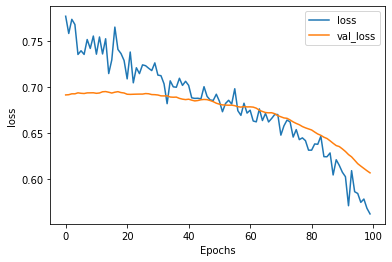

In [ ]:
# display history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Menampilkan prediksi
y_pred = np.rint(model.predict(testing_padded))
y_pred

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [ ]:
#confision matrix
con_mat = tf.math.confusion_matrix(labels=testing_labels, predictions=y_pred).numpy()
con_mat

array([[74, 29],
       [13, 79]], dtype=int32)

In [ ]:
#Menormalisasi confision matrix 
classes=[0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes,columns = classes)
con_mat_df

0     1
0  0.72  0.28
1  0.14  0.86

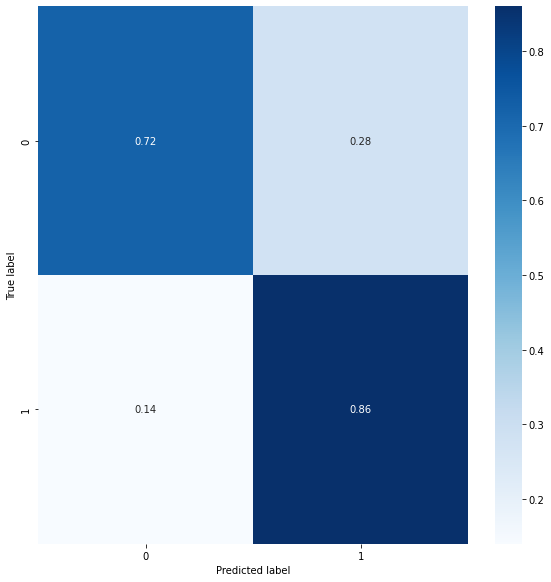

In [ ]:
# display confision matrix
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Uji Coba Model

In [ ]:
# test sentence
sentence = ["Kamu cantik sekali"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(np.rint(model.predict(padded)))

[[0.]]


**Kesimpulan**
***
Pada Program yang telah dibuat, memiliki akurasi yang cukup tinggi yaitu sebesar 0.7582. Tujuan dari program ini adalah agar mesin dapat mengidentifikasi antara kalimat negatif dan positif pada komentar di instagram. Program ini juga menggunakan NLP yang mana NLP adalah Natural language processing (NLP) adalah cabang dari kecerdasan buatan yang berhubungan dengan interaksi antara komputer dan manusia menggunakan bahasa alami. 